In [181]:
%load_ext autoreload
%autoreload 2

from environment import ReversalEnvironment
from trainer import train_test_split
from config import Conf
import numpy as np

config = Conf()
config.provide_actions = False
train_layouts, test_layouts, all_layouts = train_test_split(port_dim=config.port_dim, init_port=False)
print(train_layouts)
env = ReversalEnvironment(config, all_layouts)

# num_trials = 40
inputs, targets, groundtruths = env.get_batch(config.num_trials, {'dropout': 0.0})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 0  1]
 [ 1  0]
 [ 0  2]
 ...
 [48 47]
 [48 49]
 [49 48]]


In [182]:
import torch
inputs_ = env.get_log()['inputs']['data'][0]
print(torch.all(inputs == inputs_))

targets_ = env.get_log()['targets']['data'][0]
print(torch.all(targets == targets_))

groundtruths_ = env.get_log()['groundtruths']['data'][0]
print(torch.all(groundtruths == groundtruths_))

p_A_ = env.get_log()['p_A_high']['data'][0]

print(inputs.shape)

tensor(True)
tensor(True)
tensor(True)
torch.Size([128, 82, 104])


In [183]:
inputs.shape

torch.Size([128, 82, 104])

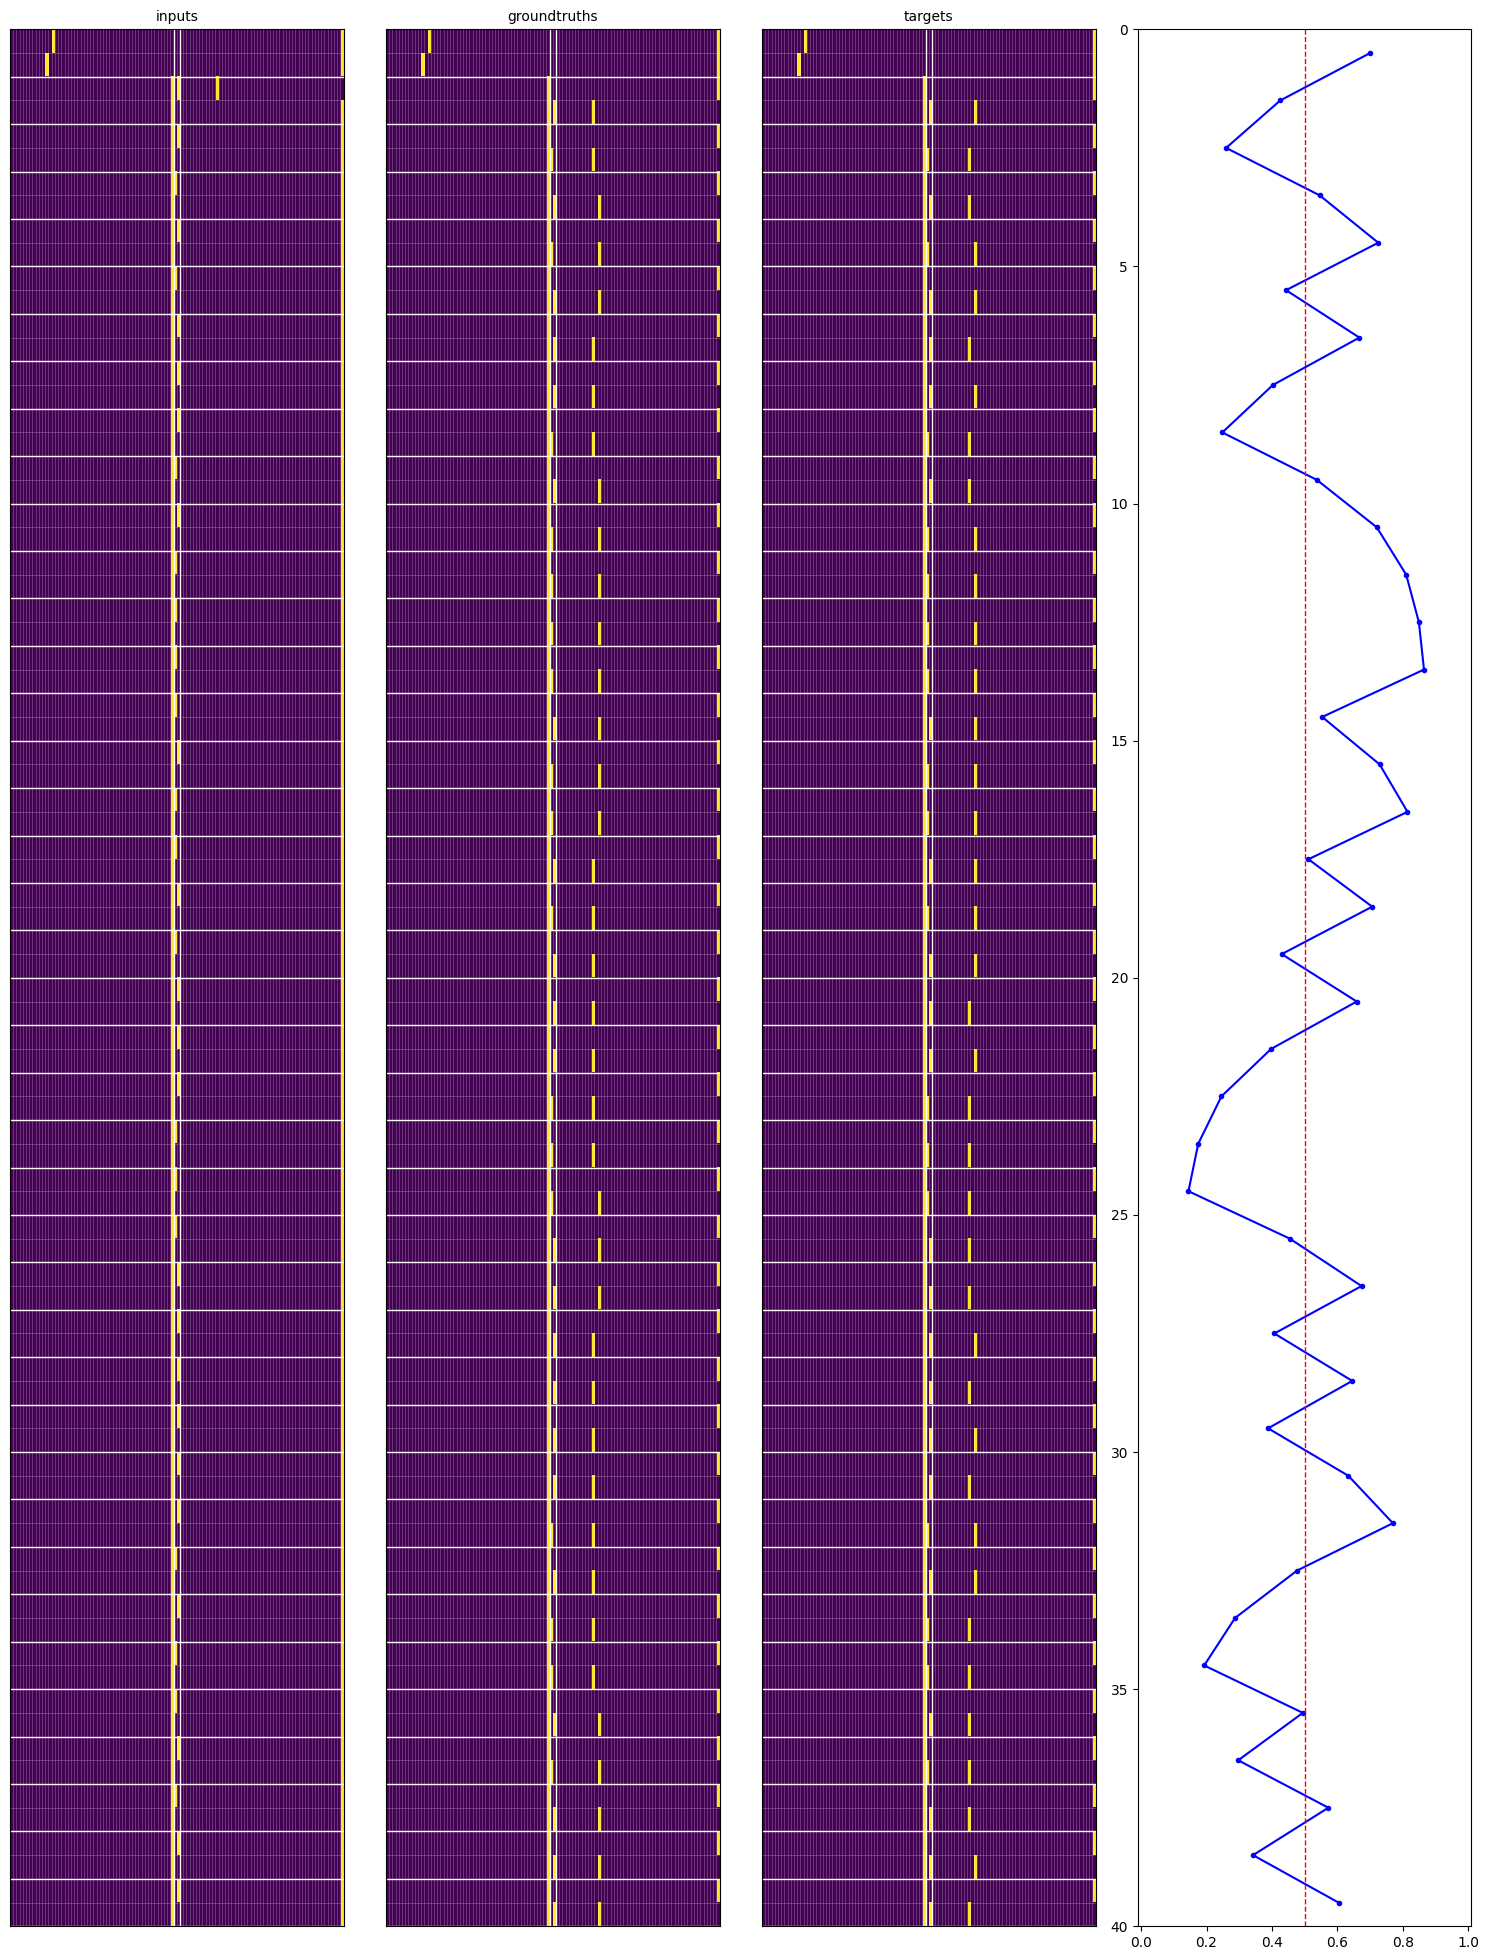

In [184]:
b = 0
num_trials = 40

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(15, num_trials//2))
if config.pre_trial:
    offset = 2
else:
    offset = 0
    
def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto', interpolation='none')
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(0,num_trials):
        ax.axhline(y=i * env.config.trial_len+offset-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs_[b, :Conf.trial_len * num_trials, :], title='inputs')
display_mat(axes[1], groundtruths_[b, :Conf.trial_len * num_trials, :], title='groundtruths')
display_mat(axes[2], targets_[b, :Conf.trial_len * num_trials, :], title='targets')
display_curve(axes[3], p_A_[b, :num_trials, :], title='targets')

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

[0 1 2 3 4 5 6 7 8 9]
[3 7]
proportion copied:  0.03677591463414634


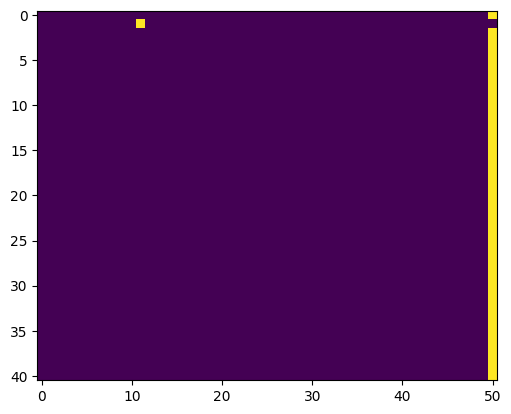

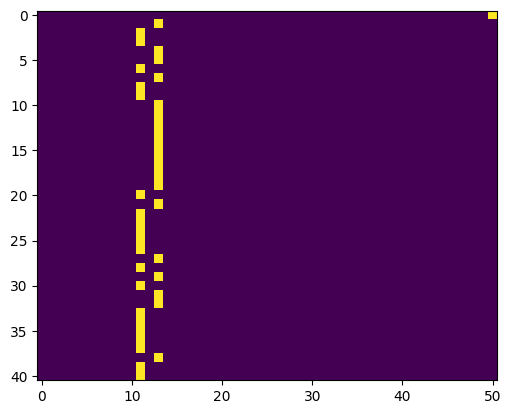

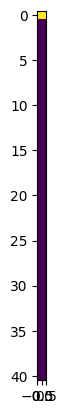

In [185]:
a = np.arange(10)
print(a)
print(a[3::4])

_, _,action_inputs = env.split_data(inputs_)
choice_inputs = action_inputs[:, ::config.trial_len, :]

_, _, action_targets = env.split_data(targets_)
choice_targets = action_targets[:, config.trial_len-1::config.trial_len, :]

k = 0
plt.imshow(choice_inputs[k])
plt.figure()
plt.imshow(choice_targets[k])
plt.figure()
identical = np.expand_dims(np.argmax(choice_inputs, axis=-1) == np.argmax(choice_targets, axis=-1), -1)
plt.imshow(identical[k])
print('proportion copied: ', np.sum(identical) / identical.size)


In [150]:
import os
from model import SimpleRNN
from trainer import ReversalTrainer
from scheduler import ReversalScheduler

# Initialize model, curriculum, loss function and optimizer
load_dir = os.path.join(os.getcwd(), Conf.save_dir)
model = SimpleRNN(Conf)
# model.load_state_dict(torch.load(os.path.join(load_dir, 'weights_4000.pth')))

optimizer_func = torch.optim.AdamW
optimizer_kwargs = {"lr": Conf.lr, "weight_decay": Conf.weight_regularization, "amsgrad": Conf.amsgrad}
scheduler_func = torch.optim.lr_scheduler.LinearLR
scheduler_kwargs = {"start_factor": 1.0, "end_factor": 0.1, "total_iters": Conf.decay_epochs}
env_scheduler = ReversalScheduler(total_iters=Conf.dropout_decay_epochs)

trainer = ReversalTrainer(model, 
                          Conf, 
                          optimizer_func, 
                          scheduler_func,
                          env_scheduler=env_scheduler, 
                          optimizer_kwargs=optimizer_kwargs, 
                          scheduler_kwargs=scheduler_kwargs)

trainer.train()

Using standard RNN
2024-02-02/b138133/p_0.7_lr_1e-04-1e-05_batchsize_64_h_128_wreg_1e-06_hreg_3e-04_thresh_None_wgain_5e-01_lrdecay_10000_dropoutdecay_1000/13:06
Making directory:  ../summaries/2024-02-02/b138133/p_0.7_lr_1e-04-1e-05_batchsize_64_h_128_wreg_1e-06_hreg_3e-04_thresh_None_wgain_5e-01_lrdecay_10000_dropoutdecay_1000/13:06
Epoch 1
{'dropout': 0.0}
TRAIN
Accuracy each step (a):	nothing: 0.0,	nothing: 0.0,	nothing: 0.0,	choice: 3.8
Accuracy each step (x):	reward: 2.4,	a: 1.6,	b: 0.0,	nothing: 0.0
INFO:trainer:Train loss {'weight': 1.993583282455802e-05, 'activity': 0.2219802588224411, 'x': -0.0, 'r': -0.0, 'a': 0.8542374968528748}
TEST
Accuracy each step (a):	nothing: 0.0,	nothing: 0.0,	nothing: 0.0,	choice: 3.2
Accuracy each step (x):	reward: 6.5,	a: 4.7,	b: 0.0,	nothing: 0.0
INFO:trainer:Test loss {'weight': 1.993583282455802e-05, 'activity': 0.2222382128238678, 'x': -0.0, 'r': -0.0, 'a': 0.8579115271568298}
INFO:trainer:Completed epoch 0 with train loss 45.868511497974396 

KeyboardInterrupt: 

In [109]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def partition_trials(arr, t_axis=1):
    arr_trial = np.array_split(arr, arr.shape[t_axis]//Conf.trial_len, axis=t_axis)
    arr_trial = np.stack(arr_trial, axis=1)
    return arr_trial

def partition_all(arrs, t_axis=1):
    return [partition_trials(arr, t_axis=t_axis) for arr in arrs]

def argmax_all(arrs, onehot_axis=-1):
    return [np.argmax(arr, axis=onehot_axis) for arr in arrs]

def unpack_data_dict(data_dict):
    return data_dict['inputs'], data_dict['targets'], data_dict['choices'], data_dict['ground_truth'], data_dict['p_A_high'], data_dict['hidden']

def detect_anomalies(h, thresholds = Conf.threshold - 0.01):
    # thresholds = 4.99
    anomaly = h > thresholds
    return np.any(anomaly, axis=(1,2,3))

504, 1000, 5, 256
504, 256, n_p_bins, 5
3, 9, n_p_bins, 5


In [44]:
# Open the HDF5 file
load_dir = '../run_data_old_env/'

%load_ext autoreload
%autoreload 2

import h5py
from plotting import *

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    chunk_size_trial = Conf.num_trials_test
    chunk_size_t = Conf.num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        lens.append(file[key].shape[1])
    lens = np.unique(lens)
    n_chunks = np.min(lens) // chunk_size_trial

    # Read and process in chunks
    print(n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        anomalous_batches = detect_anomalies(hidden_trial)
        # mean, bin_count = get_means(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, n_p_bins=50)
        # means.append(mean)
        # bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
here
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices
Dataset: /ground_truth
Dataset: /hidden
Dataset: /inputs
Dataset: /p_A_high
Dataset: /targets
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
1
(504, 1000, 8, 21) (504, 1000, 8, 10) (504, 1000, 8, 10) (504, 1000, 8, 256)
(504, 1000, 8) (504, 1000, 8) (504, 1000, 8)


In [53]:
a = np.ones((3,4,5))
np.pad(a, ((1,0), (0,0), (0,0)))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]])

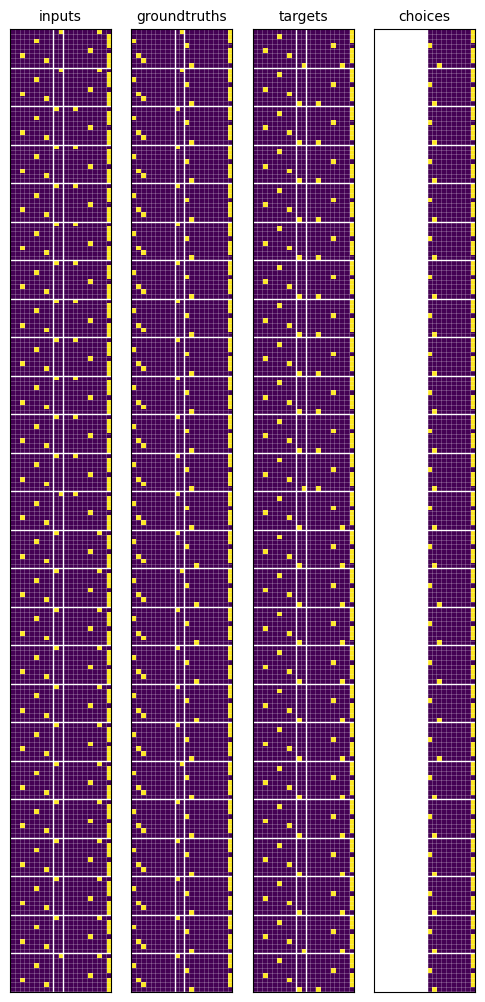

In [64]:
b = 0
t = 200

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(6, num_trials))

def pad_array(arr):
    if arr.shape[-1] == Conf.a_dim:
        return np.pad(arr, ((0,0), (Conf.x_dim + Conf.r_dim,0)), constant_values=np.nan)
    else:
        return arr
    
# q: how to set nan colour on matplotlib imshow?
# a:

def display_mat(ax, data, title=''):
    data = data.clone().numpy() if type(data) == torch.Tensor else data
    data = pad_array(data)
    ax.imshow(data)
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1, t//Conf.trial_len + 1):
        ax.axhline(y=i * env.config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

display_mat(axes[0], inputs[b, :t, :], title='inputs')
display_mat(axes[1], ground_truth[b, :t, :], title='groundtruths')
display_mat(axes[2], targets[b, :t, :], title='targets')
display_mat(axes[3], choices[b, :t, :], title='choices')

In [89]:
# Open the HDF5 file
load_dir = '../run_data_new_env/'

%load_ext autoreload
%autoreload 2

import h5py
from plotting import *

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    chunk_size_trial = Conf.num_trials_test
    chunk_size_t = Conf.num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        print(key, file[key].shape)
        lens.append(file[key].shape[1])
    lens = np.unique(lens)
    # n_chunks = np.min(lens) // chunk_size_trial
    n_chunks = 1
    # Read and process in chunks
    print(n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        anomalous_batches = detect_anomalies(hidden_trial)
        # mean, bin_count = get_means(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, n_p_bins=50)
        # means.append(mean)
        # bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../run_data_new_env/data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [70]:
type(targets)

numpy.ndarray

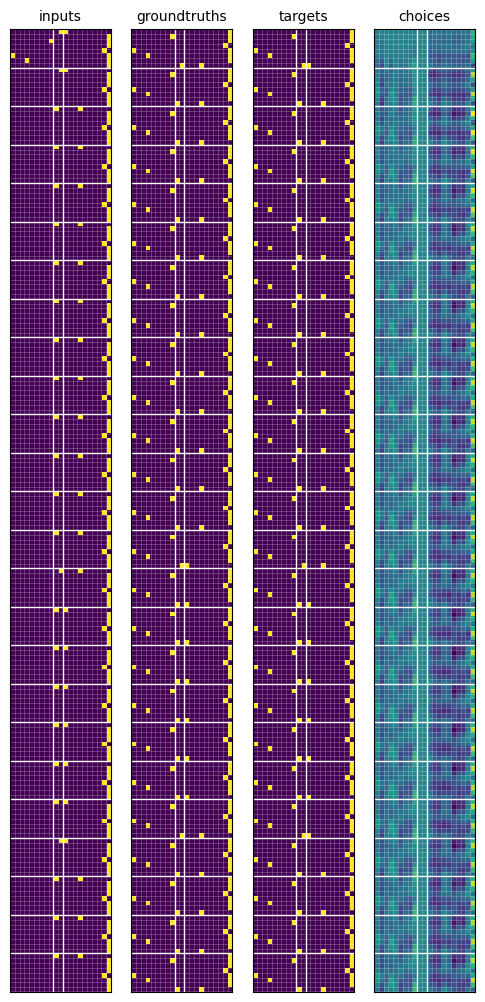

In [72]:
b = 0
t = 200

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(6, num_trials))

def display_mat(ax, data, title=''):
    data = data.clone().numpy() if type(data) == torch.Tensor else data
    ax.imshow(data)
    ax.axvline(x=env.config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=env.config.r_dim + env.config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1, t//Conf.trial_len + 1):
        ax.axhline(y=i * env.config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

display_mat(axes[0], inputs[b, :t, :], title='inputs')
display_mat(axes[1], ground_truth[b, :t, :], title='groundtruths')
display_mat(axes[2], targets[b, :t, :], title='targets')
display_mat(axes[3], choices[b, :t, :], title='choices')

100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 88.9


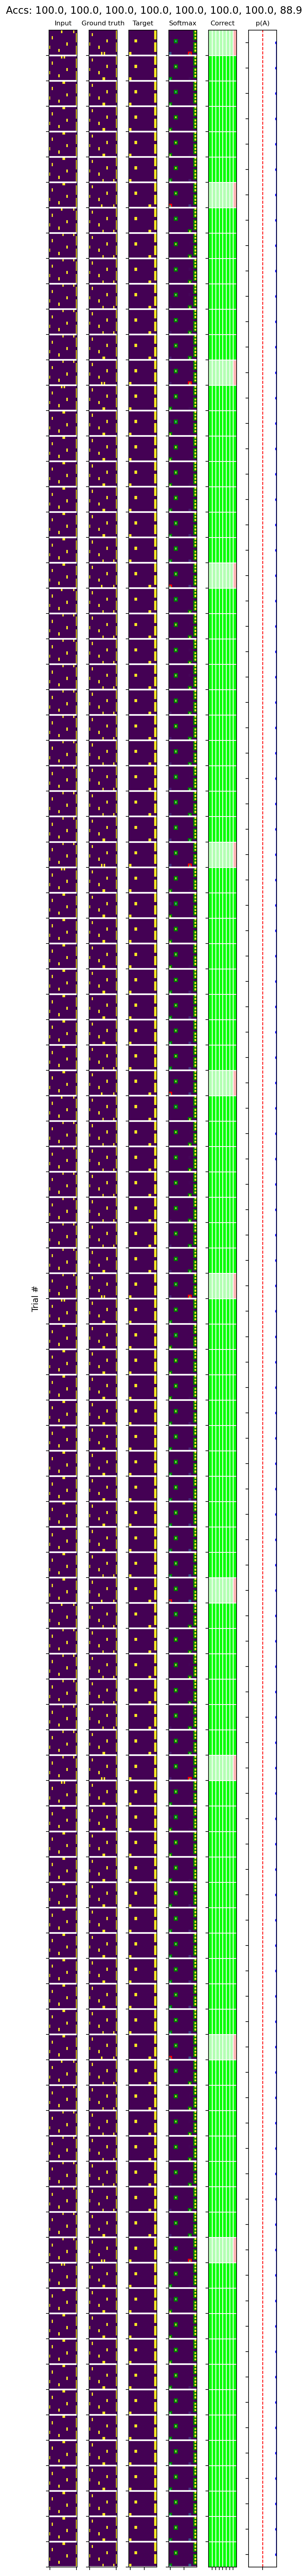

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jo/notebooks_paper/model/run_data_new/panel_0_h5.png'

In [40]:
plot_trials(inputs, ground_truth, targets[:,:,-Conf.a_dim:], choices[:,:,-Conf.a_dim:], np.ones((504,1000)), fname=f'panel_{i}_h5.png', trials=100, b=10)

In [1]:
%load_ext autoreload
%autoreload 2

from model.logger import LearningLogger
from environment import ReversalEnvironment, train_test_split
from model import SimpleRNN
from config import Conf

config = Conf()
logger = LearningLogger()
model = SimpleRNN(config)

train_layouts, test_layouts, _ = train_test_split()
env = ReversalEnvironment(config, layouts=train_layouts)
logger.add_pointer([model, env])

ModuleNotFoundError: No module named 'model.logger'; 'model' is not a package

In [14]:
logger.get_logs()

model {'hiddens': [], 'logits': []}
environment {'inputs': [], 'targets': [], 'groundtruths': [], 'p_A_high': []}


{'model': {'hiddens': [], 'logits': []},
 'environment': {'inputs': [],
  'targets': [],
  'groundtruths': [],
  'p_A_high': []}}

In [9]:
env.__class__.__module__

'environment'

In [16]:
a = {'a':2, 'b':3}
b = {**a, 'c':4}
print(b)

{'a': 2, 'b': 3, 'c': 4}


In [9]:
import torch

model = torch.nn.Linear(10, 10)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
s = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.1, total_iters=10)

for i in range(20):
    print(s.get_last_lr())
    opt.step()
    s.step()

[0.01]
[0.0091]
[0.0082]
[0.007300000000000001]
[0.0064]
[0.0055000000000000005]
[0.004600000000000001]
[0.0037000000000000006]
[0.0028000000000000004]
[0.0019000000000000004]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]
[0.0010000000000000005]


In [60]:
%load_ext autoreload
%autoreload 2

from environment import SimpleSlotEnvironment
from trainer import SimpleSlotTrainer
from model import SimpleRNN
from scheduler import ReversalScheduler
from itertools import permutations
from config_slot import ConfSlot
import numpy as np
import torch

config = ConfSlot()
print(config.port_dim, config.trial_len)
layouts = [p for p in permutations(range(config.port_dim), config.trial_len)]
layouts = np.array(layouts)
n_layouts = layouts.shape[0]
# q: random selection of elements from a list (layouts) without replacement
train_idxs = np.random.choice(np.arange(n_layouts), size=int(0.8*n_layouts), replace=False)
train_layouts = layouts[train_idxs]

train_env = SimpleSlotEnvironment(config, train_layouts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9 4


In [61]:
inputs, targets, groundtruths = train_env.get_batch(num_trials=config.num_trials)
print(inputs.shape)

torch.Size([128, 16, 10])


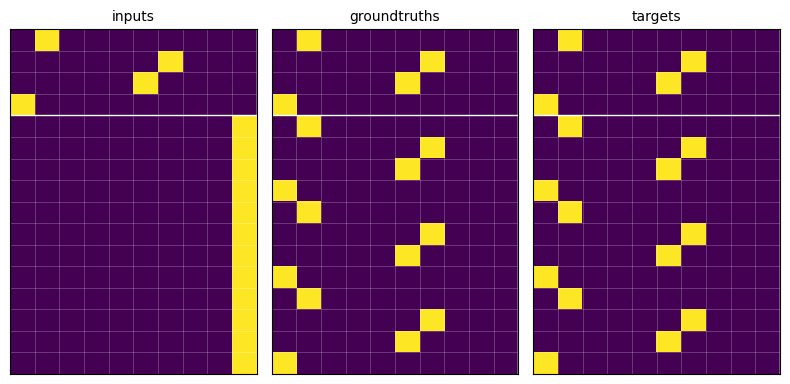

In [62]:
b = 0

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto')
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [39]:
model = SimpleRNN(config)

Using standard RNN


In [40]:
# model.load_state_dict(torch.load(os.path.join(load_dir, 'weights_4000.pth')))
config.lr = config.lr
config.batch_size = 128
optimizer_func = torch.optim.AdamW
optimizer_kwargs = {"lr": config.lr, "weight_decay": config.weight_regularization, "amsgrad": config.amsgrad}
scheduler_func = torch.optim.lr_scheduler.LinearLR
scheduler_kwargs = {"start_factor": 1.0, "end_factor": 0.1, "total_iters": config.decay_epochs}
env_scheduler = ReversalScheduler(total_iters=config.dropout_decay_epochs)

trainer = SimpleSlotTrainer(model, 
                          config, 
                          optimizer_func, 
                          scheduler_func,
                          env_scheduler=env_scheduler, 
                          optimizer_kwargs=optimizer_kwargs, 
                          scheduler_kwargs=scheduler_kwargs)

trainer.train()

2024-02-05/b138133/11:28
Making directory:  ../summaries/2024-02-05/b138133/11:28
Epoch 1
{'dropout': 0.0}
TRAIN
x tensor([16.6667,  9.6354, 10.9375, 12.5000])
INFO:trainer:Train loss {'weight': 1.4446268323808908e-05, 'activity': 0.03126596659421921, 'x': 2.2438466548919678, 'r': nan, 'a': nan}
TEST
x tensor([15.6250,  7.0312, 10.1562, 13.2812])
INFO:trainer:Test loss {'weight': 1.4446268323808908e-05, 'activity': 0.0312512069940567, 'x': 2.245727062225342, 'r': nan, 'a': nan}
INFO:trainer:Completed epoch 0 with train loss nan in 0.5711s
Epoch 2
{'dropout': 0.0}
TRAIN
x tensor([10.4167, 13.2812, 13.8021, 17.4479])
INFO:trainer:Train loss {'weight': 1.4553618711943273e-05, 'activity': 0.0451708622276783, 'x': 2.1896908283233643, 'r': nan, 'a': nan}
TEST
x tensor([11.9792, 14.8438,  9.3750, 14.3229])
INFO:trainer:Test loss {'weight': 1.4553618711943273e-05, 'activity': 0.04565013572573662, 'x': 2.1914098262786865, 'r': nan, 'a': nan}
INFO:trainer:Completed epoch 1 with train loss nan in

KeyboardInterrupt: 

In [41]:
hidden = None
config.batch_size = 605
with torch.no_grad():
    inputs, targets, groundtruths = trainer.test_env.get_batch(config.num_trials)
    # Convert data to tensors
    data_tensor = inputs.to(dtype=config.dtype, device=config.dev)
    target_tensor = targets.to(dtype=config.dtype, device=config.dev)

"""Loop through trials (chunks of 4 timesteps)."""
# Forward pass
logits, hidden, hiddens = model(data_tensor, hidden)

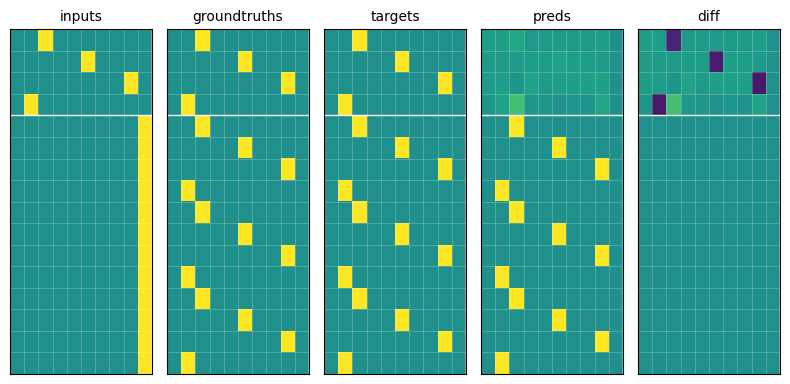

In [42]:
b = 1

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto', vmin=-1, vmax=1)
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')
preds = torch.nn.functional.softmax(logits.detach()[b, :, :], dim=-1)
display_mat(axes[3], preds, title='preds')
display_mat(axes[4], preds - targets[b, :, :], title='diff')


plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [46]:
hiddens_detached = hiddens.detach()

h_means = []
for i in range(config.port_dim):
    layouts = trainer.test_env.layouts[trainer.test_env.idxs]
    batches, offsets = np.where(layouts == i)
    
    h_collected = []
    for batch, offset in zip(batches, offsets):
        h_shift = hiddens_detached[batch, offset:offset+(config.num_trials-1)*config.trial_len, :]
        h_collected.append(h_shift)

    h_collected = torch.stack(h_collected)
    print(h_collected.shape)
    h_mean = torch.mean(h_collected, dim=0).numpy()

    h_means.append(h_mean)
    # layouts = np.argmax(inputs[:, :config.trial_len, :], axis=-1)

h_means = np.stack(h_means, axis=0)
print(h_means.shape)

torch.Size([270, 12, 256])
torch.Size([280, 12, 256])
torch.Size([265, 12, 256])
torch.Size([254, 12, 256])
torch.Size([276, 12, 256])
torch.Size([285, 12, 256])
torch.Size([285, 12, 256])
torch.Size([251, 12, 256])
torch.Size([254, 12, 256])
(9, 12, 256)


In [48]:
h_means_reshape = np.reshape(h_means, (config.port_dim, config.num_trials-1, config.trial_len, config.hidden_dim))
h_means_all = np.mean(h_means_reshape, axis=1)

neurons = []
for i in range(config.hidden_dim):
    _, idx = np.where(h_means_all[:, :, i] == np.max(h_means_all[:, :, i]))
    if idx != (config.target_shift % config.trial_len):
        neurons.append(i)

print(neurons)

[1, 2, 4, 9, 11, 20, 26, 30, 35, 37, 39, 41, 43, 48, 50, 54, 60, 63, 64, 67, 69, 71, 79, 82, 86, 89, 90, 96, 99, 106, 107, 114, 116, 117, 125, 126, 127, 130, 139, 140, 142, 143, 153, 157, 162, 163, 165, 167, 171, 184, 191, 193, 206, 210, 212, 213, 216, 222, 225, 226, 232, 233, 249, 251, 254]


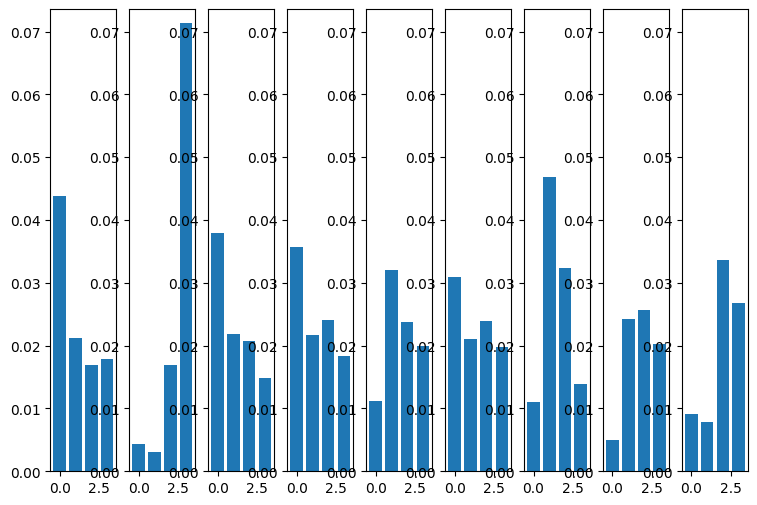

In [59]:
k=37
fig, axes = plt.subplots(1, config.port_dim, figsize=(config.port_dim, 6))
vmax = np.max(h_means[:, :, k])
for i in range(config.port_dim):
    h_ = np.reshape(h_means[i, :, k], (config.num_trials-1, config.trial_len))
    h_ = np.mean(h_, axis=0)
    axes[i].bar(np.arange(config.trial_len), h_, label=str(i))
    axes[i].set_ylim([0, vmax])

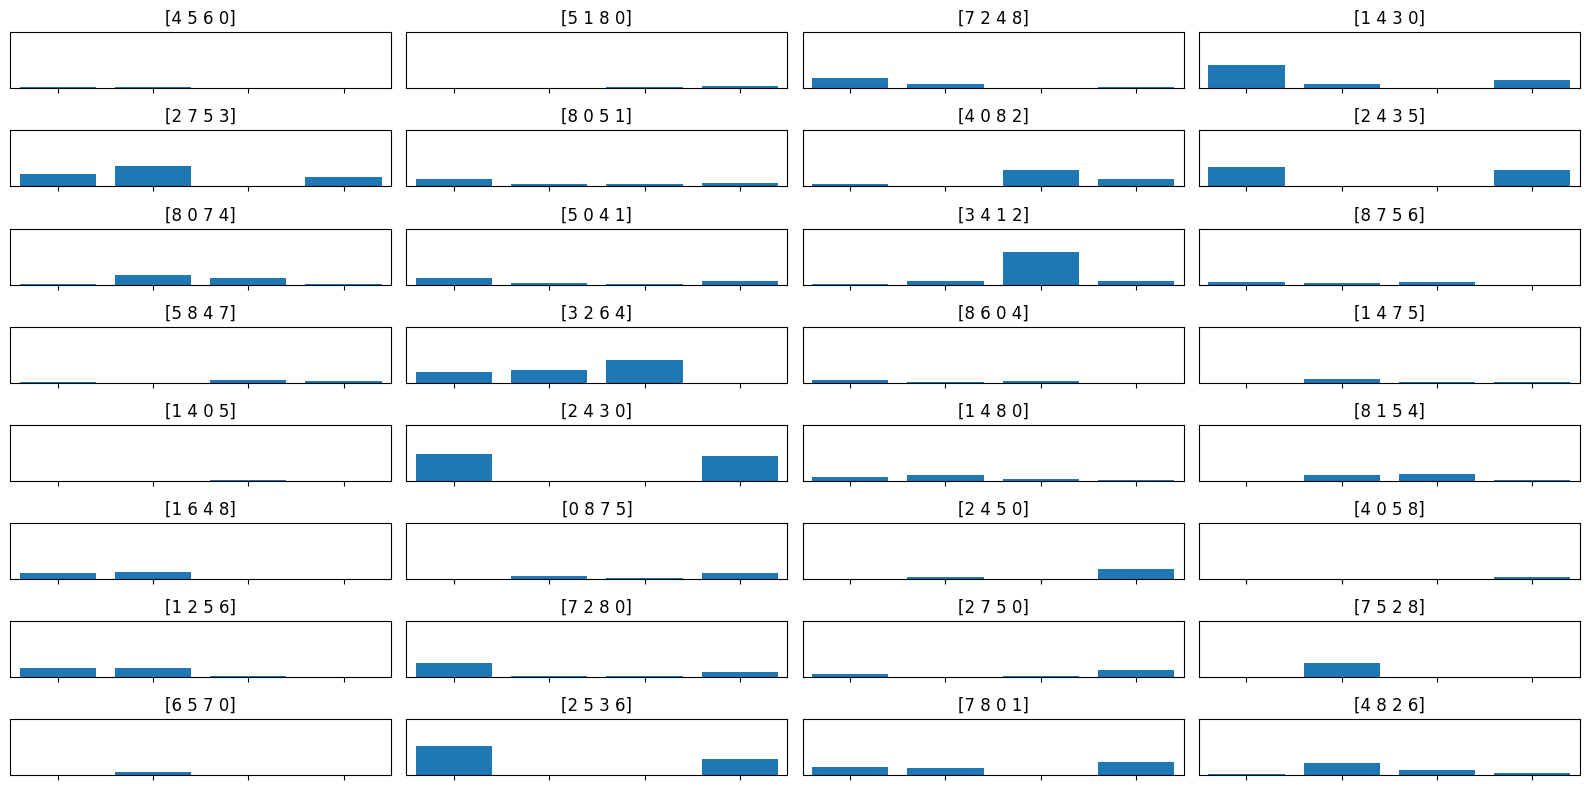

In [400]:
fig, axes = plt.subplots(8, 4, figsize=(16,8), sharex=True, sharey=True)
h = hiddens.detach().numpy()
k = 0
vmax = np.max(h[:,:,k])
for i, ax in enumerate(axes.flatten()):
    h_ = h[i, config.trial_len:, k]
    h_ = h_.reshape(config.num_trials-1, config.trial_len)
    h_mean = np.mean(h_, axis=0)
    ax.bar(np.arange(config.trial_len), h_mean)
    ax.xaxis.set_ticks(np.arange(0, config.trial_len))
    ax.xaxis.set_ticklabels([])
    ax.set_xlim([-0.5, config.trial_len-0.5])
    ax.set_ylim([0, vmax])
    ax.yaxis.set_visible(False)
    layout = trainer.test_env.layouts[trainer.test_env.idxs[i]]
    ax.set_title(layout)

plt.tight_layout()

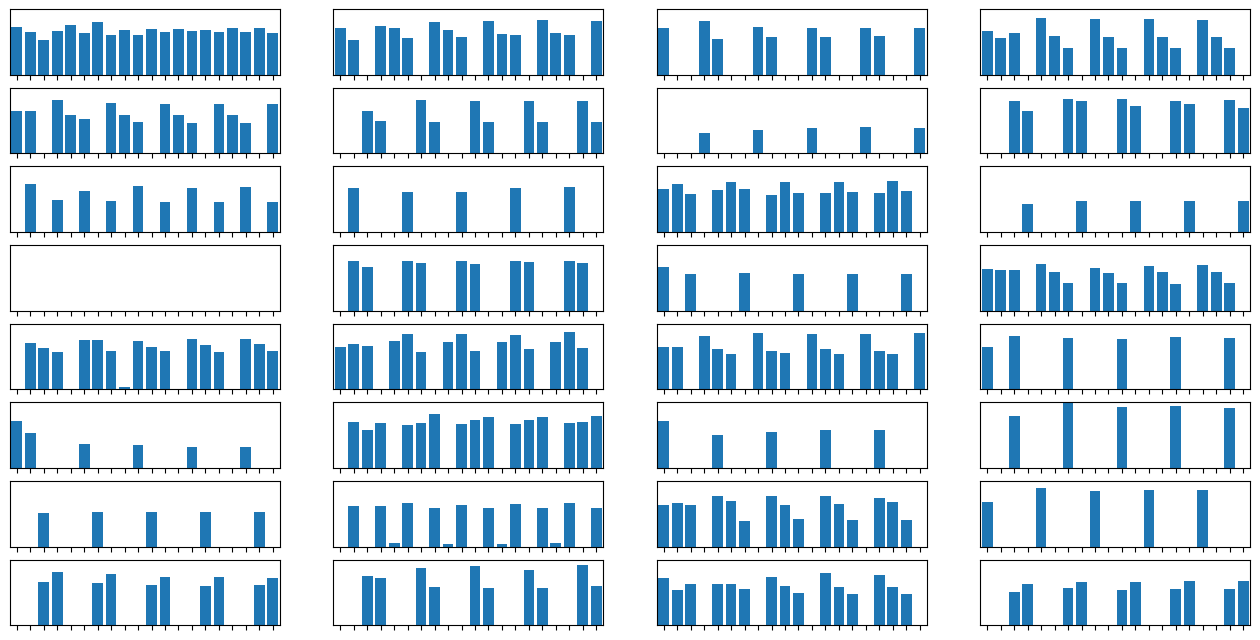

In [386]:
fig, axes = plt.subplots(8, 4, figsize=(16,8), sharex=True, sharey=True)
h = hiddens.detach().numpy()
k = 121
vmax = np.max(h[:,:,k])
for i, ax in enumerate(axes.flatten()):
    ax.bar(np.arange(config.trial_len * config.num_trials), h[i,:,k])
    ax.xaxis.set_ticks(np.arange(0, config.trial_len * config.num_trials))
    ax.xaxis.set_ticklabels([])
    ax.set_xlim([-0.5, config.trial_len * config.num_trials-0.5])
    ax.set_ylim([0, vmax])
    ax.yaxis.set_visible(False)

In [171]:
%load_ext autoreload
%autoreload 2

from environment import ReversalEnvironment
from trainer import ReversalTrainer, train_test_split
from model import SimpleRNN
from scheduler import ReversalScheduler
from itertools import permutations
from config import Conf
import numpy as np
import torch

config = Conf()
train_layouts, test_layouts, all_layouts = train_test_split(config.port_dim)
print(train_layouts.shape)
train_env = ReversalEnvironment(config, train_layouts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(93600, 3)


In [172]:
inputs, targets, groundtruths = train_env.get_batch(config.num_trials, {'dropout': 0.0})
print(inputs.shape)

torch.Size([256, 160, 104])


In [167]:
model = SimpleRNN(config)

Using standard RNN


In [168]:
# model.load_state_dict(torch.load(os.path.join(load_dir, 'weights_4000.pth')))
config.lr = config.lr
config.batch_size = 128
optimizer_func = torch.optim.AdamW
optimizer_kwargs = {"lr": config.lr, "weight_decay": config.weight_regularization, "amsgrad": config.amsgrad}
scheduler_func = torch.optim.lr_scheduler.LinearLR
scheduler_kwargs = {"start_factor": 1.0, "end_factor": 0.1, "total_iters": config.decay_epochs}
env_scheduler = ReversalScheduler(total_iters=config.dropout_decay_epochs)

trainer = ReversalTrainer(model, 
                          config, 
                          optimizer_func, 
                          scheduler_func,
                          env_scheduler=env_scheduler, 
                          optimizer_kwargs=optimizer_kwargs, 
                          scheduler_kwargs=scheduler_kwargs)

print(trainer.test_env.layouts)

trainer.train()

2024-02-05/b138133/13:27
[[ 0 27 34]
 [ 0 34 27]
 [ 1 27 34]
 ...
 [48 29 15]
 [49 15 29]
 [49 29 15]]
Making directory:  ../summaries/2024-02-05/b138133/13:27
Epoch 1
{'dropout': 0.0}
TRAIN
x tensor([  0.,   0., 100., 100.])
r tensor([ 0.5208,  2.3438, 10.1562, 65.6250])
a tensor([0.0000, 0.0000, 0.0000, 2.6042])
INFO:trainer:Train loss {'weight': 2.2905618607182987e-05, 'activity': 0.03790036961436272, 'x': 3.5475997924804688, 'r': -0.0, 'a': -0.0}
TEST
x tensor([  0.,   0., 100., 100.])
r tensor([ 1.0417,  3.1250, 11.4583, 63.0208])
a tensor([0.0000, 0.0000, 0.0000, 2.3438])
INFO:trainer:Test loss {'weight': 2.2905618607182987e-05, 'activity': 0.03795338794589043, 'x': 3.5452048778533936, 'r': -0.0, 'a': -0.0}
INFO:trainer:Completed epoch 0 with train loss 192.09827780723572 in 0.5738s
Epoch 2
{'dropout': 0.0}
TRAIN
x tensor([  0.,   0., 100., 100.])
r tensor([ 0.0000,  0.0000,  0.0000, 64.3229])
a tensor([0.0000, 0.0000, 0.0000, 2.6042])
INFO:trainer:Train loss {'weight': 2.3118727

KeyboardInterrupt: 

In [162]:
hidden = None
config.batch_size = 128

with torch.no_grad():
    inputs, targets, groundtruths = trainer.test_env.get_batch(config.num_trials, env_scheduler.get_params())
    # Convert data to tensors
    data_tensor = inputs.to(dtype=config.dtype, device=config.dev)
    target_tensor = targets.to(dtype=config.dtype, device=config.dev)

"""Loop through trials (chunks of 4 timesteps)."""
# Forward pass
logits, hidden, hiddens = model(data_tensor, hidden)

accuracies, steps = trainer.get_all_accuracies(logits, target_tensor)

x tensor([ 73.4375,  65.3646, 100.0000, 100.0000])
r tensor([94.0104, 96.3542, 35.1562, 56.5104])
a tensor([ 0.5208, 17.1875, 15.8854,  0.7812])


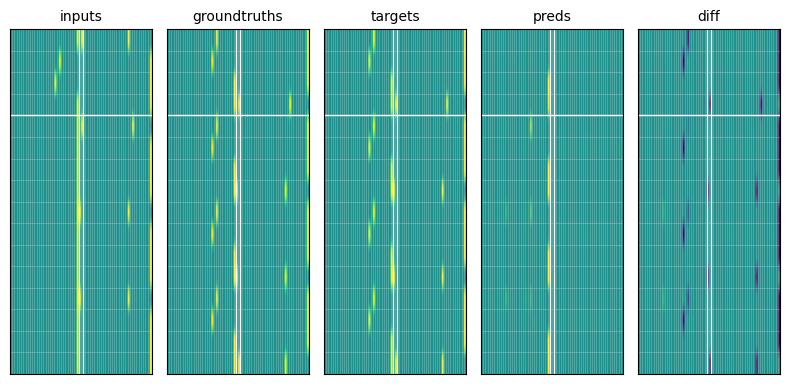

In [164]:
b = 0

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto', vmin=-1, vmax=1)
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')
preds = torch.nn.functional.softmax(logits.detach()[b, :, :], dim=-1)
try: display_mat(axes[3], preds, title='preds')
except: pass

try: display_mat(axes[4], preds - targets[b, :, :], title='diff')
except: pass


plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle